<img src="data/photutils_banner.svg" width=500 alt="Photutils logo">

# Photutils

- Code: https://github.com/astropy/photutils
- Documentation: https://photutils.readthedocs.io/en/stable/
- Issue Tracker:  https://github.com/astropy/photutils/issues

## Photutils can be used for:

- Background and background noise estimation
- Source Detection and Extraction
  - DAOFIND and IRAF's starfind
  - Image segmentation
  - local peak finder
- Aperture photometry
- PSF photometry
- ePSF building
- PSF matching
- Centroids
- Morphological properties
- Elliptical isophote analysis


## In this section, we will:

- Learn how to perform aperture photometry
- Learn how to use photutils' image segmentation subpackage

---

## Preliminaries

In [2]:
# Initial imports
import numpy as np
import matplotlib.pyplot as plt

# Change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'

# Run the %matplotlib magic command to enable inline plotting
# in the current notebook.  Choose one of these:
%matplotlib inline
# %matplotlib notebook

### Load the data

We'll start by reading data and error arrays from FITS files.  These are cutouts from the HST Extreme-Deep Field (XDF) taken with WFC3/IR in the F160W filter.

In [3]:
from astropy.io import fits

In [4]:
sci_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_sci.fits'
rms_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_rms.fits'
sci_hdulist = fits.open(sci_fn)
rms_hdulist = fits.open(rms_fn)

sci_hdulist[0].header['BUNIT'] = 'electron/s'

Print some info about the data.

In [5]:
sci_hdulist.info()

Filename: data/xdf_hst_wfc3ir_60mas_f160w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (200, 200)   float32   


Define the data and error arrays.

In [6]:
data = sci_hdulist[0].data.astype(np.float)
error = rms_hdulist[0].data.astype(np.float)

Extract the data header and create a WCS object.

In [7]:
from astropy.wcs import WCS

In [8]:
hdr = sci_hdulist[0].header
wcs = WCS(hdr)

Display the data.

In [9]:
from astropy.visualization import simple_norm

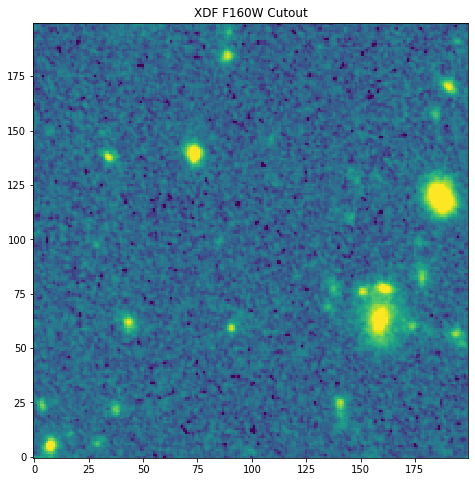

In [10]:
plt.figure(figsize=(8, 8))
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm)
plt.title('XDF F160W Cutout');

---
# Part 1:  Aperture Photometry

Photutils provides circular, elliptical, and rectangular aperture shapes (plus annulus versions of each).  These are names of the aperture classes, defined in pixel coordinates:

* `CircularAperture`
* `CircularAnnulus`

* `EllipticalAperture`
* `EllipticalAnnulus`

* `RectangularAperture`
* `RectangularAnnulus`

Along with variants of each, defined in celestial coordinates:

* `SkyCircularAperture`
* `SkyCircularAnnulus`

* `SkyEllipticalAperture`
* `SkyEllipticalAnnulus`

* `SkyRectangularAperture`
* `SkyRectangularAnnulus`

These look something like this:
<img src='data/apertures.png' alt='Figure of aperture shapes' width=700px>

## Methods for handling aperture/pixel intersection

In general, the apertures will only partially overlap some of the pixels in the data.

There are three methods for handling the aperture overlap with the pixel grid of the data array.

<img src="data/photutils_aperture_methods.svg">

NOTE:  the `subpixels` keyword is ignored for the **'exact'** and **'center'** methods.

### Perform circular-aperture photometry on some sources in the XDF

First, we define a circular aperture at a given position and radius (in pixels).

In [11]:
from photutils import CircularAperture

In [12]:
position = (90.73, 59.43)  # (x, y) pixel position
radius = 5.  # pixels
aperture = CircularAperture(position, r=radius)

In [13]:
aperture

<CircularAperture([90.73, 59.43], r=5.0)>

In [14]:
print(aperture)

Aperture: CircularAperture
positions: [90.73, 59.43]
r: 5.0


We can plot the aperture on the data using the aperture `plot()` method:

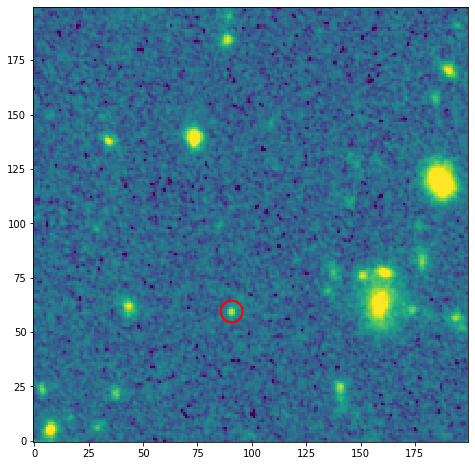

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(data, norm=norm)
aperture.plot(color='red', lw=2)

Now let's perform photometry on the data using the `aperture_photometry()` function.  **The default aperture method is 'exact'.**

Also note that the input data is assumed to have zero background.  If that is not the case, please see the documentation for the `photutils.background` subpackage for tools to help subtract the background.

<div class="alert alert-warning alert-block"> 
<h3 style="margin-top:0;">Learn More:</h3>

See the [local background subtraction notebook](photutils_local_backgrounds.ipynb) for examples of local background subtraction.
</div>

The background was already subtracted for our XDF example data.

In [16]:
from photutils import aperture_photometry

In [17]:
phot = aperture_photometry(data, aperture)
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,90.73,59.43,0.12039154582527045


The output is an Astropy `QTable` (Quantity Table) with sum of data values within the aperture (using the defined pixel overlap method).

The table also contains metadata, which is accessed by the `meta` attribute of the table.  The metadata is stored as a python (ordered) dictionary:

In [18]:
phot.meta

OrderedDict([('name', 'Aperture photometry results'),
             ('version', 'astropy: 3.2.3, photutils: 0.7.1'),
             ('aperture_photometry_args', "method='exact', subpixels=5")])

In [19]:
phot.meta['version']

'astropy: 3.2.3, photutils: 0.7.1'

Aperture photometry using the **'center'** method gives a slightly different (and less accurate) answer:

In [20]:
phot = aperture_photometry(data, aperture, method='center')
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,90.73,59.43,0.1202922910979396


Now perform aperture photometry using the **'subpixel'** method with `subpixels=5`:

These parameters are equivalent to SExtractor aperture photometry.

In [21]:
phot = aperture_photometry(data, aperture, method='subpixel', subpixels=5)
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,90.73,59.43,0.12040869806049159


## Photometric Errors

We can also input an error array to get the photometric errors.

In [22]:
phot = aperture_photometry(data, aperture, error=error)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008021175633656936


The error array in our XDF FITS file represents only the background error.  If we want to include the Poisson error of the source we need to calculate the **total** error:

$\sigma_{\mathrm{tot}} = \sqrt{\sigma_{\mathrm{b}}^2 +
                  \frac{I}{g}}$
                  
where $\sigma_{\mathrm{b}}$ is the background-only error,
$I$ are the data values, and $g$ is the "effective gain".

The "effective gain" is the value (or an array if it's variable across an image) needed to convert the data image to count units (e.g. electrons or photons), where Poisson statistics apply.

Photutils provides a `calc_total_error()` function to perform this calculation.

In [23]:
from photutils.utils import calc_total_error

In [24]:
# this time include the Poisson error of the source

# our data array is in units of e-/s
# so the "effective gain" should be the exposure time
eff_gain = hdr['TEXPTIME']
tot_error = calc_total_error(data, error, eff_gain)

phot = aperture_photometry(data, aperture, error=tot_error)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417


The total error increased only slightly because this is a small faint source.

## Units

In [25]:
# input the data units
import astropy.units as u

`Quantity` inputs for data and error are also allowed.  Note that the unit must be the same for the `data` and `error` inputs.

In [26]:
unit = u.electron / u.s  # unit for the data and error arrays
phot = aperture_photometry(data * unit, aperture, error=tot_error * unit)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,electron / s
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417


## Performing aperture photometry at multiple positions

Now let's perform aperture photometry for three sources (all with the same aperture size).  We simply define three (x, y) positions.

In [27]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radius = 5.
apertures = CircularAperture(positions, r=radius)

An aperture object with multiple positions can be indexed or sliced to get a subset of apertures:

In [28]:
apertures[1]  # aperture for the second position

<CircularAperture([ 73.63, 139.41], r=5.0)>

In [29]:
apertures[0:2]  # apertures for the first two positions

<CircularAperture([[ 90.73,  59.43],
                   [ 73.63, 139.41]], r=5.0)>

Let's plot all three apertures on the data.

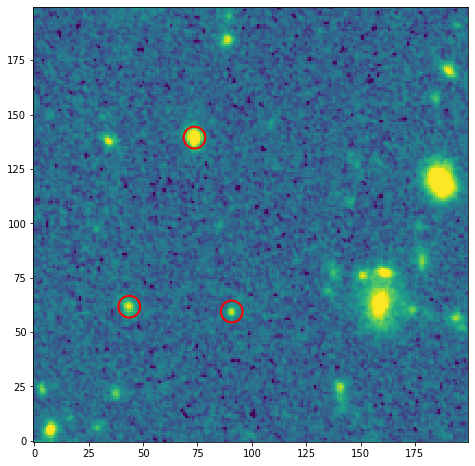

In [30]:
plt.figure(figsize=(8, 8))
plt.imshow(data, norm=norm)
apertures.plot(color='red', lw=2)

Now let's perform aperture photometry.

In [31]:
phot = aperture_photometry(data * unit, apertures, error=tot_error * unit)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,electron / s
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417
2,73.63,139.41,0.6150243632978061,0.00816628074162013
3,43.62,61.63,0.21352615994892402,0.008069761430877863


Each source is a row in the table and is given a unique **id** (the first column).

## Adding columns to the photometry table

We can add columns to the photometry table.  Let's calculate the signal-to-noise (SNR) ratio of our sources and add it as a new column to the table.

In [32]:
snr = phot['aperture_sum'] / phot['aperture_sum_err']  # units will cancel

phot['snr'] = snr
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr
,pix,pix,electron / s,electron / s,
int64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988
2,73.63,139.41,0.6150243632978061,0.00816628074162013,75.31266469486938
3,43.62,61.63,0.21352615994892402,0.008069761430877863,26.460033766536732


Now calculate the F160W AB magnitude and add it to the table.

In [33]:
f160w_zpt = 25.9463  # HST/WFC3 F160W zero point

# NOTE that the log10() function can be applied only to dimensionless quantities
# so we use the value() method to get the number value of the aperture sum
abmag = -2.5 * np.log10(phot['aperture_sum'].value) + f160w_zpt

phot['abmag'] = abmag
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,abmag
,pix,pix,electron / s,electron / s,,
int64,float64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352
2,73.63,139.41,0.6150243632978061,0.00816628074162013,75.31266469486938,26.474069199845104
3,43.62,61.63,0.21352615994892402,0.008069761430877863,26.460033766536732,27.622672275537816


Now, using the WCS defined above, calculate the sky coordinates for these objects and add it to the table.

In [34]:
# convert pixel positions to sky coordinates
x, y = np.transpose(positions)
coord = wcs.pixel_to_world(x, y)

# we can add the astropy SkyCoord object directly to the table
phot['sky_coord'] = coord
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,abmag,sky_coord
,pix,pix,electron / s,electron / s,,,"deg,deg"
int64,float64,float64,float64,float64,float64,float64,object
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352,"53.158891500867604,-27.765002141410175"
2,73.63,139.41,0.6150243632978061,0.00816628074162013,75.31266469486938,26.474069199845104,"53.15921313626186,-27.763669058236427"
3,43.62,61.63,0.21352615994892402,0.008069761430877863,26.460033766536732,27.622672275537816,"53.159778816470286,-27.764965241221894"


We can also add separate RA and Dec columns, if preferred.

In [35]:
phot['ra_icrs'] = coord.icrs.ra
phot['dec_icrs'] = coord.icrs.dec
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,abmag,sky_coord,ra_icrs,dec_icrs
,pix,pix,electron / s,electron / s,,,"deg,deg",deg,deg
int64,float64,float64,float64,float64,float64,float64,object,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352,"53.158891500867604,-27.765002141410175",53.15888794969764,-27.76499923317225
2,73.63,139.41,0.6150243632978061,0.00816628074162013,75.31266469486938,26.474069199845104,"53.15921313626186,-27.763669058236427",53.15920958492472,-27.76366614996854
3,43.62,61.63,0.21352615994892402,0.008069761430877863,26.460033766536732,27.622672275537816,"53.159778816470286,-27.764965241221894",53.15977526527222,-27.76496233290131


If we write the table to an ASCII file using the ECSV format, we can read it back in preserving all of the units, metadata, and SkyCoord objects.

In [36]:
phot.write('my_photometry.txt', format='ascii.ecsv')

In [37]:
# view the table on disk
!cat my_photometry.txt

# %ECSV 0.9
# ---
# datatype:
# - {name: id, datatype: int64}
# - {name: xcenter, unit: pix, datatype: float64}
# - {name: ycenter, unit: pix, datatype: float64}
# - {name: aperture_sum, unit: electron / s, datatype: float64}
# - {name: aperture_sum_err, unit: electron / s, datatype: float64}
# - {name: snr, datatype: float64}
# - {name: abmag, datatype: float64}
# - {name: sky_coord.ra, unit: deg, datatype: float64}
# - {name: sky_coord.dec, unit: deg, datatype: float64}
# - {name: ra_icrs, unit: deg, datatype: float64}
# - {name: dec_icrs, unit: deg, datatype: float64}
# meta: !!omap
# - {name: Aperture photometry results}
# - {version: 'astropy: 3.2.3, photutils: 0.7.1'}
# - {aperture_photometry_args: 'method=''exact'', subpixels=5'}
# - __serialized_columns__:
#     aperture_sum:
#       __class__: astropy.units.quantity.Quantity
#       unit: &id001 !astropy.units.Unit {unit: electron / s}
#       value: !astropy.table.SerializedColumn {name: aperture_sum}
#     aperture_sum_err:


Now read the table in ECSV format.

In [38]:
from astropy.table import QTable

In [39]:
tbl = QTable.read('my_photometry.txt', format='ascii.ecsv')
tbl

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,abmag,sky_coord,ra_icrs,dec_icrs
,pix,pix,electron / s,electron / s,,,"deg,deg",deg,deg
int64,float64,float64,float64,float64,float64,float64,object,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352,"53.158891500867604,-27.765002141410175",53.15888794969764,-27.76499923317225
2,73.63,139.41,0.6150243632978061,0.00816628074162013,75.31266469486938,26.474069199845104,"53.15921313626186,-27.763669058236427",53.15920958492472,-27.76366614996854
3,43.62,61.63,0.21352615994892402,0.008069761430877863,26.460033766536732,27.622672275537816,"53.159778816470286,-27.764965241221894",53.15977526527222,-27.76496233290131


In [40]:
tbl.meta

OrderedDict([('name', 'Aperture photometry results'),
             ('version', 'astropy: 3.2.3, photutils: 0.7.1'),
             ('aperture_photometry_args', "method='exact', subpixels=5")])

In [41]:
tbl['aperture_sum']  # Quantity array

<Quantity [0.12039155, 0.61502436, 0.21352616] electron / s>

In [42]:
tbl['sky_coord']  # SkyCoord array

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(53.1588915 , -27.76500214), (53.15921314, -27.76366906),
     (53.15977882, -27.76496524)]>

## Aperture photometry using Sky apertures

First, let's define the sky coordinates by converting our pixel coordinates.

In [43]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
x, y = np.transpose(positions)
coord = wcs.pixel_to_world(x, y)
coord

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(53.1588915 , -27.76500214), (53.15921314, -27.76366906),
     (53.15977882, -27.76496524)]>

Now define circular apertures in sky coordinates.

For sky apertures, the aperture radius must be a `Quantity`, in either pixel or angular units.

In [44]:
from photutils import SkyCircularAperture

In [45]:
radius = 5. * u.pix
sky_apers = SkyCircularAperture(coord, r=radius)
sky_apers.r

<Quantity 5. pix>

In [46]:
radius = 0.5 * u.arcsec
sky_apers = SkyCircularAperture(coord, r=radius)
sky_apers.r

<Quantity 0.5 arcsec>

When using a sky aperture in angular units, `aperture_photometry` needs the WCS transformation, which can be input via the `wcs` keyword:

In [47]:
phot = aperture_photometry(data, sky_apers, wcs=wcs)
phot

id,xcenter,ycenter,sky_center,aperture_sum
,pix,pix,"deg,deg",
int64,float64,float64,object,float64
1,90.73000000001593,59.430000000468226,"53.158891500867604,-27.765002141410175",0.14686106763789314
2,73.63000000060538,139.40999999953056,"53.15921313626186,-27.763669058236427",0.7507009236808948
3,43.620000000119944,61.63000000022339,"53.159778816470286,-27.764965241221894",0.2695146575990177


<div class="alert alert-warning alert-block"> 
<h3 style='margin-top: 0;'>Learn More:</h3>
    
Aperture Photometry in the [Extended notebook](photutils_extended.ipynb):

- Bad pixel masking
- Encircled flux
- Aperture photometry at multiple positions using multiple apertures

</div>

---
# Part 2:  Image Segmentation

Image segmentation is the process where sources are identified and labeled in an image.

The sources are detected by using a S/N threshold level - either a per-pixel threshold image or a single value for the whole image - and defining the minimum number of pixels required within a source. 

First, let's define a threshold image at 2$\sigma$ (per pixel) above the background.

In [48]:
bkg = 0.  # background level in this image
nsigma = 2.
threshold = bkg + (nsigma * error)  # threshold image, this should be background-only error

Now let's detect "8-connected" sources of minimum size 5 pixels where each pixel is 2$\sigma$ above the background.

"8-connected" pixels touch along their edges or corners. "4-connected" pixels touch along their edges. For reference, SExtractor uses "8-connected" pixels.

The result is a segmentation image (`SegmentationImage` object).  The segmentation image is the isophotal footprint of each source above the threshold: an array in which each object is labeled with an integer. As a simple example, a segmentation map containing two distinct sources might look like this:

```
0 0 0 0 0 0 0 0 0 0
0 1 1 0 0 0 0 0 0 0
1 1 1 1 1 0 0 0 2 0
1 1 1 1 0 0 0 2 2 2
1 1 1 0 0 0 2 2 2 2
1 1 1 1 0 0 0 2 2 0
1 1 0 0 0 0 2 2 0 0
0 1 0 0 0 0 2 0 0 0
0 0 0 0 0 0 0 0 0 0
```
where all of the pixels labeled `1` belong to the first source, all those labeled `2` belong to the second, and all `0` pixels are designated to be background.

In [49]:
from photutils import detect_sources

In [50]:
npixels = 5
segm = detect_sources(data, threshold, npixels)

print('Found {0} sources'.format(segm.nlabels))

Found 22 sources


Display the segmentation image.

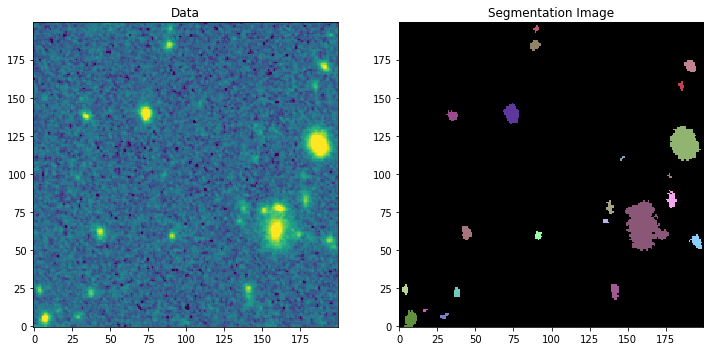

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
ax1.imshow(data, norm=norm)
lbl1 = ax1.set_title('Data')
ax2.imshow(segm, cmap=segm.make_cmap())
lbl2 = ax2.set_title('Segmentation Image')

It is better to filter (smooth) the data prior to source detection.

Let's use a 5x5 Gaussian kernel with a FWHM of 2 pixels.

In [52]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma

In [53]:
sigma = 2.0 * gaussian_fwhm_to_sigma  # FWHM = 2 pixels
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
kernel.normalize()

ssegm = detect_sources(data, threshold, npixels, filter_kernel=kernel)
print('Found {0} sources'.format(ssegm.nlabels))

Found 19 sources


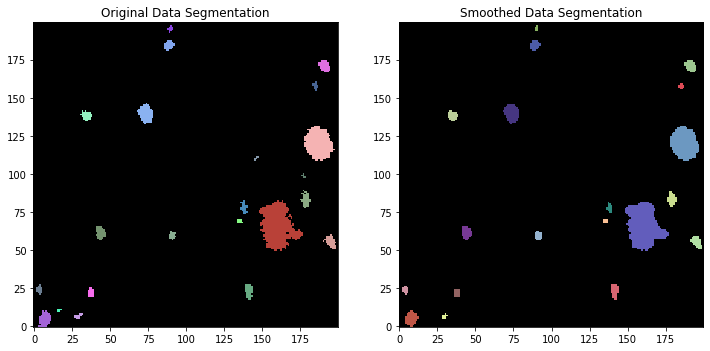

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
ax1.imshow(segm, cmap=segm.make_cmap())
lbl1 = ax1.set_title('Original Data Segmentation')
ax2.imshow(ssegm, cmap=ssegm.make_cmap())
lbl2 = ax2.set_title('Smoothed Data Segmentation')

### Source deblending

Note above that some of our detected sources were blended.  We can deblend them using the `deblend_sources()` function, which uses a combination of multi-thresholding and watershed segmentation.

How the sources are deblended can be controlled with the two keywords `nlevels` and `contrast`:
- `nlevels` is the number of multi-thresholding levels to use
- `contrast` is the fraction of the total source flux that a local peak must have to be considered as a separate object

In [55]:
from photutils import deblend_sources

Found 22 sources


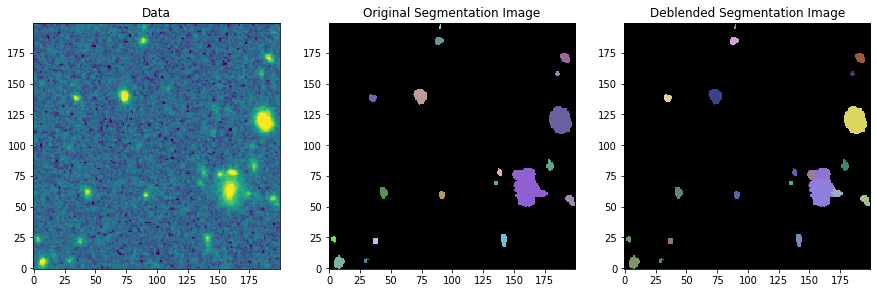

In [56]:
segm2 = deblend_sources(data, ssegm, npixels, filter_kernel=kernel,
                        contrast=0.001, nlevels=32)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
ax1.imshow(data, norm=norm)
ax1.set_title('Data')
ax2.imshow(ssegm, cmap=ssegm.make_cmap())
ax2.set_title('Original Segmentation Image')
ax3.imshow(segm2, cmap=segm2.make_cmap())
ax3.set_title('Deblended Segmentation Image')

print('Found {0} sources'.format(segm2.nlabels))

## Measure the photometry and morphological properties of detected sources

In [57]:
from photutils import source_properties

In [58]:
catalog = source_properties(data, segm2, error=error, wcs=wcs)

`catalog` is a `SourceCatalog` object.  It behaves like a list of `SourceProperties` objects, one for each source.

The `to_table` method converts the `SourceCatalog` object to a `QTable`. We will do this so we can write the table to disk for future use, but going forward in this example we will use the `SourceCatalog` object for analysis of the detected objects.

In [63]:
catalog_to_tab = catalog.to_table() # convert to QTable
catalog_to_tab.remove_columns(['sky_centroid', 'sky_centroid_icrs']) # remove skycoord columns (will be useful later on)
catalog_to_tab.write('my_detected_sources.txt', format='ascii.ecsv') # write to file

In [62]:
catalog

<photutils.segmentation.properties.SourceCatalog>
Catalog length: 22

In [ ]:
catalog[0]  # the first source

In [ ]:
catalog[0].xcentroid  # the xcentroid of the first source

Please go [here](http://photutils.readthedocs.io/en/latest/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties) to see the complete list of available source properties.

We can create a Table of isophotal photometry and morphological properties using the ``to_table()`` method of `SourceCatalog`:

In [ ]:
tbl = catalog.to_table()
tbl

Additional properties (not stored in the table) can be accessed directly via the `SourceCatalog` object.

In [ ]:
# get a single object (id=12)
obj = catalog[11]
obj.id

In [ ]:
obj

Let's plot the cutouts of the data and error images for this source. `make_cutout` will generate a cutout of the source using the minimal bounding box of the segment.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), ncols=3)
ax[0].imshow(obj.make_cutout(segm2.data))
ax[0].set_title('Source id={} Segment'.format(obj.id))
ax[1].imshow(obj.data_cutout_ma)
ax[1].set_title('Source id={} Data'.format(obj.id))
ax[2].imshow(obj.error_cutout_ma)
ax[2].set_title('Source id={} Error'.format(obj.id));

## Exercise 1

`data/xdf_hst_wfc3ir_60mas_f105w_sci.fits` is an F105W image of the same field used for the preceding examples. These images are aligned, so source positions detected in the F160W image should correspond to the same source if they are visible in the F105W image. 

In the F105W image, find the countrate in a 5-pixel aperture radius of the 3 brightest sources detected in the F160W image (hint: read in the table of detected sources that was written to disk in the previous example)

In [ ]:
# answer here 

<div class="alert alert-warning alert-block"> 
<h3 style="margin-top:0;">Learn More:</h3>
    
Image Segmentation in the [Extended notebook](photutils_extended.ipynb):

- Define a subset of source labels
- Define a subset of source properties
- Additional sources properties, such a cutout images
- Define the approximate isophotal ellipses for each source

</div>

<div class="alert alert-warning alert-block"> 
<h3 style="margin-top: 0;">PSF Photometry:</h3>
    
See the two additional notebooks on using `photutils` for PSF-fitting photometry:

- [Gaussian PSF Photometry](gaussian_psf_photometry.ipynb)
- [Image-based PSF Photometry](image_psf_photometry_withNIRCam.ipynb)

</div>